In [ ]:
import pkg_resources as pkg

path = pkg.resource_filename(__name__, "../")

import os

os.chdir(path)

In [1]:
import torch
from pytorch_lightning import LightningModule

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd

#from physioex.data import SleepPhysionet, TimeDistributedModule
#from physioex.data import datamodule
#from physioex.train.networks import TinySleepNet, ContrTinySleepNet
#from physioex.train.networks import seqsleepnet

In [2]:
def compute_projections(model, datamodule, contr=False):
    train_projections = []
    y_train_true = []
    y_train_pred = []
    first = True
    for batch in datamodule.train_dataloader():
        inputs, y_true = batch          

        y_train_true.append(y_true)
        if contr:
            projections, y_pred = model(inputs.to(model.device))
        else:
            projections, y_pred = model.encode(inputs.to(model.device))

        y_train_pred.append(y_pred.cpu().detach().numpy())
        train_projections.append(projections.cpu().detach().numpy())

        del projections, y_pred

    y_train_true = np.concatenate(y_train_true).reshape(-1)
    train_projections = np.concatenate(train_projections).reshape(
        y_train_true.shape[0], -1
    )
    y_train_pred = np.concatenate(y_train_pred).reshape(-1, 5)

    return train_projections, y_train_true, y_train_pred

In [ ]:
from physioex.data.datamodule import PhysioExDataModule

datamodule = PhysioExDataModule(
    datasets=["hmc"],
    versions=None,
    batch_size=15,
    selected_channels=["EEG"],
    sequence_length=10,
    data_folder="/mnt/guido-data/",
    preprocessing = "xsleepnet",
    target_transform= None
)

#print(datamodule.train_idx[206579])

In [ ]:
print(len(datamodule.dataset))
print("---")
print(len(datamodule.dataset[0]))
print(type(datamodule.dataset[0][0]), " ", type(datamodule.dataset[0][1]))
print("---")
print(len(datamodule.dataset[0][0]))
print(datamodule.dataset[0][1])
print("---")
print(datamodule.dataset[0][0][1].shape)
print("---")

tdl = datamodule.train_dataloader()
print(len(datamodule.train_idx))
print(datamodule.batch_size)
print(len(tdl))
print(len(tdl.dataset))
print(len(tdl.dataset[0]))
print("---")


In [5]:
from physioex.models import load_pretrained_model
import torch

Seed set to 42


In [ ]:

path_ep_scl_DCSM_BEHM_DW = "/home/tinghi/physioex/models/DCSM_BEHM_DW/ssn_ep_scl/fold=-1-epoch=18-step=57840-val_acc=0.91.ckpt"
# First, load the model without strict argument
seqsleepnet_model_DCSM_BEHM_DW = load_pretrained_model("seqsleepnet_epochscl", in_channels=1, sequence_length=21, loss_params={"class_weights": torch.tensor([7.6, 15, 2.1, 9, 6])} ,loss="scl_behm", ckpt_path=path_ep_scl_DCSM_BEHM_DW)
# Then, load the checkpoint with strict=False
checkpoint = torch.load(path_ep_scl_DCSM_BEHM_DW, map_location='cuda')
seqsleepnet_model_DCSM_BEHM_DW.load_state_dict(checkpoint['state_dict'], strict=False)

# Set the model to evaluation mode
seqsleepnet_model_DCSM_BEHM_DW.eval()


In [ ]:
path_ep_scl_DCSM_BEHM_EW = "/home/tinghi/physioex/models/DCSM_BEHM_EW/ssn_ep_scl/fold=-1-epoch=18-step=57840-val_acc=0.91.ckpt"
# First, load the model without strict argument
seqsleepnet_model_DCSM_BEHM_EW = load_pretrained_model("seqsleepnet_epochscl", in_channels=1, sequence_length=21, loss_params={"class_weights": torch.tensor([1,1,1,1,1])} ,loss="scl_behm", ckpt_path=path_ep_scl_DCSM_BEHM_EW)
# Then, load the checkpoint with strict=False
checkpoint = torch.load(path_ep_scl_DCSM_BEHM_EW, map_location='cuda')
seqsleepnet_model_DCSM_BEHM_EW.load_state_dict(checkpoint['state_dict'], strict=False)

# Set the model to evaluation mode
seqsleepnet_model_DCSM_BEHM_EW.eval()

In [6]:
path_ep_scl_HMC_BEHM_DW_CEL = "/home/tinghi/physioex/models/HMC_BEHM_DW_CEL/ssn_ep_scl/fold=-1-epoch=16-step=11624-val_acc=0.72.ckpt"
# First, load the model without strict argument
seqsleepnet_model_HMC_BEHM_DW_CEL = load_pretrained_model("seqsleepnet_epochscl", in_channels=1, sequence_length=21, loss_params={"class_weights": torch.tensor([7.6, 15, 2.1, 9, 6])} ,loss="scl_behm", ckpt_path=path_ep_scl_HMC_BEHM_DW_CEL)
# Then, load the checkpoint with strict=False
checkpoint = torch.load(path_ep_scl_HMC_BEHM_DW_CEL, map_location='cuda')
seqsleepnet_model_HMC_BEHM_DW_CEL.load_state_dict(checkpoint['state_dict'], strict=False)

# Set the model to evaluation mode
seqsleepnet_model_HMC_BEHM_DW_CEL.eval()

/home/tinghi/miniconda3/envs/tesi/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/tinghi/miniconda3/envs/tesi/lib/

BEHM weights:  tensor([ 7.6000, 15.0000,  2.1000,  9.0000,  6.0000])


/tmp/ipykernel_3036881/4076425069.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_ep_scl_HMC_BEHM_DW_CEL, map_location='cuda')


SeqSleepNetEpochScl(
  (nn): NetEpochScl(
    (epoch_encoder): EpochEncoder(
      (F2_filtbank): LearnableFilterbank()
      (F2_birnn): LSTM(32, 64, batch_first=True, bidirectional=True)
      (F2_attention): AttentionLayer()
    )
    (sequence_encoder): SequenceEncoder(
      (LSTM): GRU(128, 64, batch_first=True, bidirectional=True)
      (clf): Linear(in_features=128, out_features=5, bias=True)
    )
  )
  (wacc): MulticlassAccuracy()
  (macc): MulticlassAccuracy()
  (wf1): MulticlassF1Score()
  (mf1): MulticlassF1Score()
  (ck): MulticlassCohenKappa()
  (pr): MulticlassPrecision()
  (rc): MulticlassRecall()
  (loss): SimilarityCombinedLoss_BEHM(
    (miner): BatchEasyHardMiner(
      (distance): LpDistance()
    )
    (contr_loss): TripletMarginLoss(
      (distance): CosineSimilarity()
      (reducer): MultipleReducers(
        (reducers): ModuleDict(
          (loss): ClassWeightedReducer()
          (embedding_reg_loss): ClassWeightedReducer()
        )
        (default_reduc

## PCA components plot

### Extracting the latent space projections from the similarity model

In [ ]:
seqsleepnet_model
seqsleepnet_sum_model
seqsleepnet_conc_model
seqsleepnet_epoch_model

In [7]:
train_projections, y_train_true, y_train_pred = compute_projections(
    seqsleepnet_model_HMC_BEHM_DW_CEL, datamodule, contr=False
)
preds_snn = np.argmax(y_train_pred, axis=1)

(934590,)
(934590,)


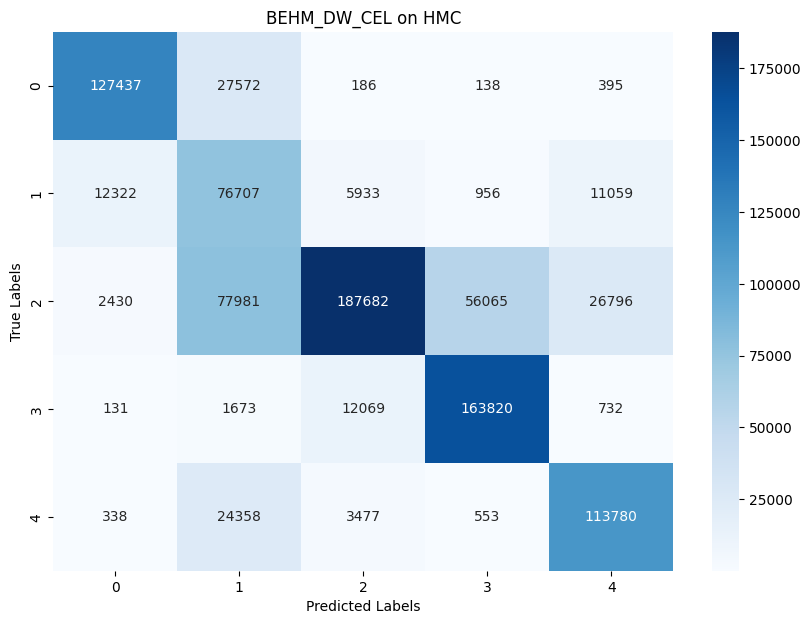

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print(y_train_true.shape)
print(preds_snn.shape)

conf_matrix = confusion_matrix(y_train_true, preds_snn)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('BEHM_DW_CEL on HMC')
plt.show()

Explained variance ratio: [0.19960114 0.09506112]
Explained variance: 0.29466227
(93459, 3)


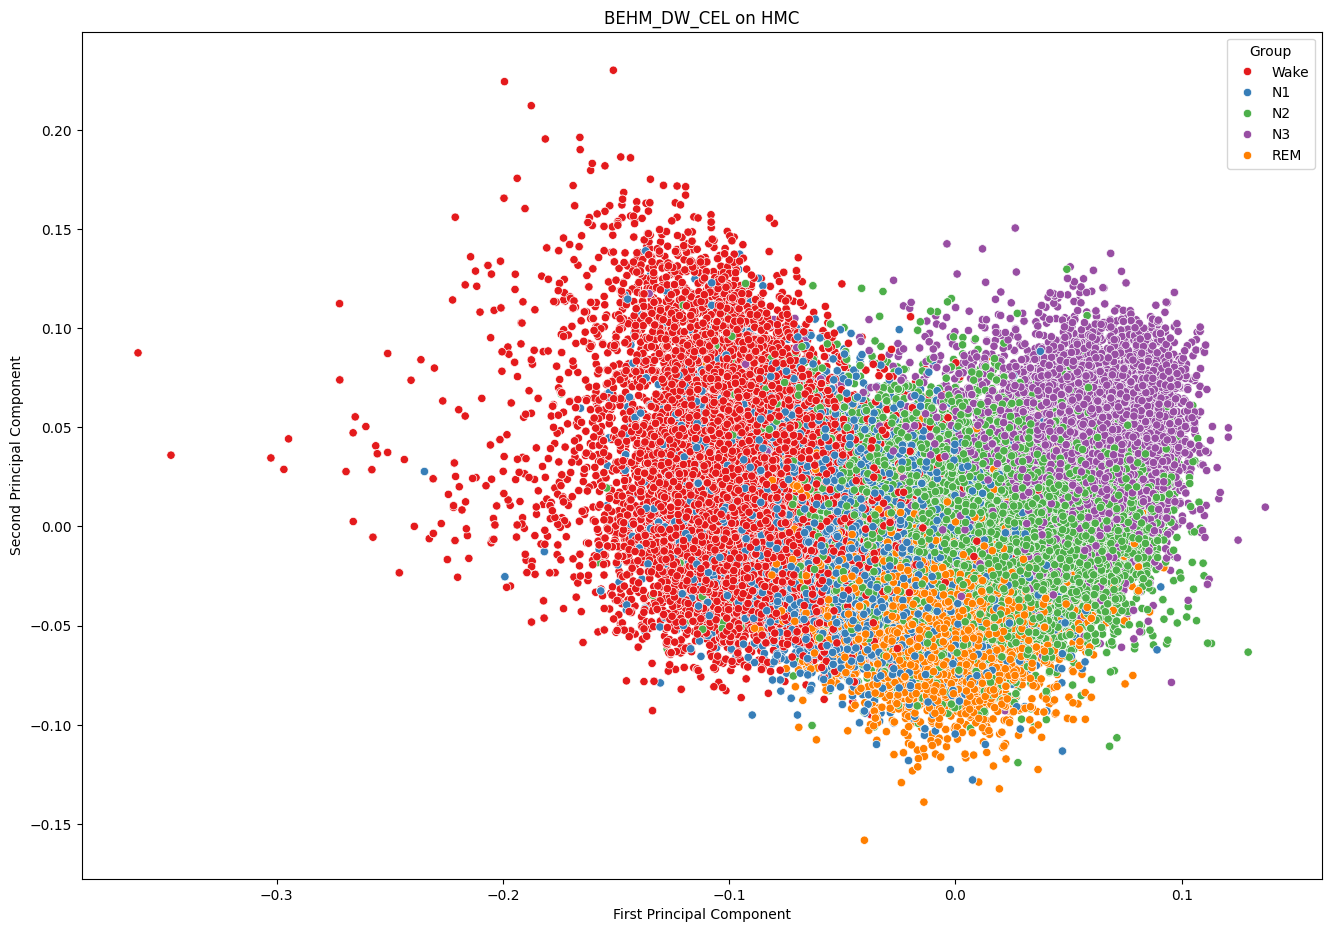

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Increase the number of components to see the variance in other components
pca = PCA(n_components=2)  # Adjust the number of components as needed
true_indx = [True for i in range(len(y_train_true))]
# Fourth PCA transformation
principal_components = pca.fit_transform(train_projections[true_indx, :])
true_positive = y_train_true[true_indx]
explained_variance = pca.explained_variance_ratio_

df_ssn = pd.DataFrame(
    {
        "First Principal Component": principal_components[:, 0],
        "Second Principal Component": principal_components[:, 1],
        "Group": true_positive,
    }
)
print("Explained variance ratio:", explained_variance)
print("Explained variance:", explained_variance.sum())

classes = {0:"Wake", 1:"N1", 2:"N2", 3:"N3", 4:"REM"}
df_ssn["Group"] = df_ssn["Group"].map(classes)

# Sample 50% of the data
df_ssn_sampled = df_ssn.sample(frac=0.1, random_state=42)
print(df_ssn_sampled.shape)
fig, axes = plt.subplots(1, 1, figsize=(16, 11))
classes=["Wake", "N1", "N2", "N3", "REM"]

'''[(df_ssn_sampled["First Principal Component"] >= -0.4)&(df_ssn_sampled["First Principal Component"] <= 0.4)]'''

# Utilizza seaborn.scatterplot
sns.scatterplot(
    data=df_ssn_sampled,
    x="First Principal Component",
    y="Second Principal Component",
    hue="Group",
    hue_order=classes,
    palette="Set1",
).set(title="BEHM_DW_CEL on HMC")

plt.show()
plt.close()

In [ ]:
train_projections_ssn, y_train_true_ssn, y_train_pred_ssn = compute_projections(
    seqsleepnet_model, datamodule, contr=False
)
preds_snn = np.argmax(y_train_pred_ssn, axis=1)
print("ssn end")

train_projections_ssn_sum, y_train_true_ssn_sum, y_train_pred_ssn_sum = compute_projections(
    seqsleepnet_sum_model, datamodule, contr=False
)
preds_snn_sum = np.argmax(y_train_pred_ssn_sum, axis=1)
print("ssn sum end")

train_projections_ssn_conc, y_train_true_ssn_conc, y_train_pred_ssn_conc = compute_projections(
    seqsleepnet_conc_model, datamodule, contr=False
)
preds_snn_conc = np.argmax(y_train_pred_ssn_conc, axis=1)
print("ssn conc end")

train_projections_ssn_epoch, y_train_true_ssn_epoch, y_train_pred_ssn_epoch = compute_projections(
    seqsleepnet_epoch_model, datamodule, contr=False
)
preds_snn_epoch = np.argmax(y_train_pred_ssn_epoch, axis=1)
print("ssn epoch end")

In [10]:
true_indx_ssn = [True for i in range(len(y_train_true_ssn))]
true_indx_ssn_sum = [True for i in range(len(y_train_true_ssn_sum))]
true_indx_ssn_conc = [True for i in range(len(y_train_true_ssn_conc))]
true_indx_ssn_epoch = [True for i in range(len(y_train_true_ssn_epoch))]
#true_indx = [True for i in range(len(contr_y_train_true))]

### K-medoids

In [ ]:
import pandas as pd
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import torch
import math

'''seqsleepnet_model
seqsleepnet_sum_model
seqsleepnet_conc_model
seqsleepnet_epoch_model'''

In [9]:
train_projections = train_projections
y_train_true = y_train_true
figure_title = "SSN-Epoch-BEHM_EW" + " SimilarityCombinedLoss"

In [ ]:
mean = datamodule.dataset.scaling[0][0]
std = datamodule.dataset.scaling[0][1]
print(mean.shape)
print(std.shape)

In [11]:
train_projections_df = pd.DataFrame(train_projections)
y_train_true_df = pd.DataFrame(y_train_true, columns=['y_train_true'])

result_df = pd.concat([train_projections_df, y_train_true_df], axis=1)

In [ ]:
# Sample the dataset
sampled_df = result_df.sample(n=20000, random_state=0)  # Adjust the sample size as needed
medoids_idxs = {}

# Iterate over each unique class in the 'y_train_true' column
for class_label in sampled_df['y_train_true'].unique():
    # Filter the dataframe to include only rows of the current class
    class_df = sampled_df[sampled_df['y_train_true'] == class_label]
    
    # Apply k-medoids clustering with k=1
    kmedoids = KMedoids(n_clusters=1, random_state=0)
    kmedoids.fit(class_df.iloc[:, :-1])  # Exclude the 'y_train_true' column
    
    # Retrieve the index of the cluster center in the original sampled_df
    medoid_index = class_df.index[kmedoids.medoid_indices_][0]
    print(f"Index of the cluster center in the original sampled_df for class {class_label}: {medoid_index}")
    medoids_idxs[class_label] = medoid_index

In [13]:

medoid_0 = datamodule.dataset[math.floor(medoids_idxs[0]/10)][0][medoids_idxs[0]%10]
medoid_1 = datamodule.dataset[math.floor(medoids_idxs[1]/10)][0][medoids_idxs[1]%10]
medoid_2 = datamodule.dataset[math.floor(medoids_idxs[2]/10)][0][medoids_idxs[2]%10]
medoid_3 = datamodule.dataset[math.floor(medoids_idxs[3]/10)][0][medoids_idxs[3]%10]
medoid_4 = datamodule.dataset[math.floor(medoids_idxs[4]/10)][0][medoids_idxs[4]%10]

In [ ]:
# Sample data for demonstration
first_dim = torch.arange(29)
second_dim = torch.arange(129)

third_dim0 = (10 ** ((medoid_0[0, first_dim[:, None], second_dim]*std + mean)/20) - np.finfo(float).eps).squeeze()
third_dim1 = (10 ** ((medoid_1[0, first_dim[:, None], second_dim]*std + mean)/20) - np.finfo(float).eps).squeeze()
third_dim2 = (10 ** ((medoid_2[0, first_dim[:, None], second_dim]*std + mean)/20) - np.finfo(float).eps).squeeze()
third_dim3 = (10 ** ((medoid_3[0, first_dim[:, None], second_dim]*std + mean)/20) - np.finfo(float).eps).squeeze()
third_dim4 = (10 ** ((medoid_4[0, first_dim[:, None], second_dim]*std + mean)/20) - np.finfo(float).eps).squeeze()

third_dim0 = third_dim0[:, :50]
third_dim1 = third_dim1[:, :50]
third_dim2 = third_dim2[:, :50]
third_dim3 = third_dim3[:, :50]
third_dim4 = third_dim4[:, :50]
second_dim = second_dim[:50]

# Create a meshgrid for the x and y coordinates
X, Y = torch.meshgrid(first_dim, second_dim, indexing='ij')

#vmin = min(third_dim0.min(), third_dim1.min(), third_dim2.min(), third_dim3.min(), third_dim4.min())
#vmax = max( third_dim0.max(), third_dim1.max(), third_dim2.max(), third_dim3.max(), third_dim4.max())

# Create a figure with a custom grid layout
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1])
# Add a title to the entire figure
fig.suptitle(figure_title, fontsize=25)

# First row, first column
ax1 = fig.add_subplot(gs[0, 0])
#c1 = ax1.pcolormesh(X, Y, third_dim0, shading='auto', vmin=vmin, vmax=vmax)
c1 = ax1.pcolormesh(X, Y, third_dim0, shading='auto')
fig.colorbar(c1, ax=ax1, label='Intensity')
ax1.set_xlabel("Spectral Column")
ax1.set_ylabel("Frequency Bin")
ax1.set_title('Wake Centroid Spectrogram')

# First row, second column
ax2 = fig.add_subplot(gs[0, 1])
#c2 = ax2.pcolormesh(X, Y, third_dim1, shading='auto', vmin=vmin, vmax=vmax)
c2 = ax2.pcolormesh(X, Y, third_dim1, shading='auto')
fig.colorbar(c2, ax=ax2, label='Intensity')
ax2.set_xlabel("Spectral Column")
ax2.set_ylabel("Frequency Bin")
ax2.set_title('N1 Centroid Spectrogram')

# Second row, first column
ax3 = fig.add_subplot(gs[1, 0])
#c3 = ax3.pcolormesh(X, Y, third_dim2, shading='auto', vmin=vmin, vmax=vmax)
c3 = ax3.pcolormesh(X, Y, third_dim2, shading='auto')
fig.colorbar(c3, ax=ax3, label='Intensity')
ax3.set_xlabel("Spectral Column")
ax3.set_ylabel("Frequency Bin")
ax3.set_title('N2 Centroid Spectrogram')

# Second row, second column
ax4 = fig.add_subplot(gs[1, 1])
#c4 = ax4.pcolormesh(X, Y, third_dim3, shading='auto', vmin=vmin, vmax=vmax)
c4 = ax4.pcolormesh(X, Y, third_dim3, shading='auto')
fig.colorbar(c4, ax=ax4, label='Intensity')
ax4.set_xlabel("Spectral Column")
ax4.set_ylabel("Frequency Bin")
ax4.set_title('N3 Centroid Spectrogram')

# Third row, centered column (spanning both columns)
ax5 = fig.add_subplot(gs[2, 0])
#c5 = ax5.pcolormesh(X, Y, third_dim4, shading='auto', vmin=vmin, vmax=vmax)
c5 = ax5.pcolormesh(X, Y, third_dim4, shading='auto')
fig.colorbar(c5, ax=ax5, label='Intensity')
ax5.set_xlabel("Spectral Column")
ax5.set_ylabel("Frequency Bin")
ax5.set_title('REM Centroid Spectrogram')

plt.tight_layout()
plt.show()

### Plotting the first 2 PCA components

In [ ]:
# Increase the number of components to see the variance in other components
pca = PCA(n_components=2)  # Adjust the number of components as needed

# First PCA transformation
principal_components_ssn = pca.fit_transform(train_projections_ssn[true_indx_ssn, :])
true_positive_ssn = y_train_true_ssn[true_indx_ssn]
explained_variance_ssn = pca.explained_variance_ratio_

df_ssn = pd.DataFrame(
    {
        "First Principal Component": principal_components_ssn[:, 0],
        "Second Principal Component": principal_components_ssn[:, 1],
        #"Third Principal Component": principal_components_ssn[:, 2],
        "Group": true_positive_ssn,
    }
)
print("Explained variance ratio for ssn:", explained_variance_ssn)
print("Explained variance:", explained_variance_ssn.sum())

# Second PCA transformation
principal_components_ssn_sum = pca.fit_transform(train_projections_ssn_sum[true_indx_ssn_sum, :])
true_positive_ssn_sum = y_train_true_ssn_sum[true_indx_ssn_sum]
explained_variance_ssn_sum = pca.explained_variance_ratio_

df_ssn_sum = pd.DataFrame(
    {
        "First Principal Component": principal_components_ssn_sum[:, 0],
        "Second Principal Component": principal_components_ssn_sum[:, 1],
        #"Third Principal Component": principal_components_ssn_sum[:, 2],
        "Group": true_positive_ssn_sum,
    }
)
print("Explained variance ratio for ssn_sum:", explained_variance_ssn_sum)
print("Explained variance:", explained_variance_ssn_sum.sum())

# Third PCA transformation
principal_components_ssn_conc = pca.fit_transform(train_projections_ssn_conc[true_indx_ssn_conc, :])
true_positive_ssn_conc = y_train_true_ssn_conc[true_indx_ssn_conc]
explained_variance_ssn_conc = pca.explained_variance_ratio_

df_ssn_conc = pd.DataFrame(
    {
        "First Principal Component": principal_components_ssn_conc[:, 0],
        "Second Principal Component": principal_components_ssn_conc[:, 1],
        #"Third Principal Component": principal_components_ssn_conc[:, 2],
        "Group": true_positive_ssn_conc,
    }
)
print("Explained variance ratio for ssn_conc:", explained_variance_ssn_conc)
print("Explained variance:", explained_variance_ssn_conc.sum())

# Fourth PCA transformation
principal_components_ssn_epoch = pca.fit_transform(train_projections_ssn_epoch[true_indx_ssn_epoch, :])
true_positive_ssn_epoch = y_train_true_ssn_epoch[true_indx_ssn_epoch]
explained_variance_ssn_epoch = pca.explained_variance_ratio_

df_ssn_epoch = pd.DataFrame(
    {
        "First Principal Component": principal_components_ssn_epoch[:, 0],
        "Second Principal Component": principal_components_ssn_epoch[:, 1],
        #"Third Principal Component": principal_components_ssn_epoch[:, 2],
        "Group": true_positive_ssn_epoch,
    }
)
print("Explained variance ratio for ssn_epoch:", explained_variance_ssn_epoch)
print("Explained variance:", explained_variance_ssn_epoch.sum())

In [9]:
classes = {0:"Wake", 1:"N1", 2:"N2", 3:"N3", 4:"REM"}
df_ssn["Group"] = df_ssn["Group"].map(classes)
df_ssn_epoch["Group"] = df_ssn_epoch["Group"].map(classes)
df_ssn_conc["Group"] = df_ssn_conc["Group"].map(classes)
df_ssn_sum["Group"] = df_ssn_sum["Group"].map(classes)

In [ ]:
print("Base", df_ssn["Group"].unique())
print("Epoch", df_ssn_epoch["Group"].unique())
print("Conc", df_ssn_conc["Group"].unique())
print("Sum", df_ssn_sum["Group"].unique())

---

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
classes=["Wake", "N1", "N2", "N3", "REM"]

sns.scatterplot(
    data=df_ssn_epoch[(df_ssn_epoch["First Principal Component"] >= -0.4)&(df_ssn_epoch["First Principal Component"] <= 0.4)],
    x="First Principal Component",
    y="Second Principal Component",
    hue="Group",
    hue_order=classes,
    palette="Set1",
    ax=axes[0,1],
).set(title="SeqSleepNet SCL Epoch encoding")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Define the classes variable
classes = ["Wake", "N1", "N2", "N3", "REM"]

fig = plt.figure(figsize=(8, 6))

# First subplot
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(
    df_ssn["First Principal Component"],
    df_ssn["Second Principal Component"],
    df_ssn["Third Principal Component"],
    c=df_ssn["Group"].apply(lambda x: classes.index(x)),
    cmap="Set1"
)
ax1.set_title("SeqSleepNet SCL")
ax1.set_xlabel("First Principal Component")
ax1.set_ylabel("Second Principal Component")
ax1.set_zlabel("Third Principal Component")

plt.show()
plt.close()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Define the classes variable
classes = ["Wake", "N1", "N2", "N3", "REM"]

fig = plt.figure(figsize=(16, 11))

# First subplot
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.scatter(
    df_ssn["First Principal Component"],
    df_ssn["Second Principal Component"],
    df_ssn["Third Principal Component"],
    c=df_ssn["Group"].apply(lambda x: classes.index(x)),
    cmap="Set1"
)
ax1.set_title("SeqSleepNet SCL")
ax1.set_xlabel("First Principal Component")
ax1.set_ylabel("Second Principal Component")
ax1.set_zlabel("Third Principal Component")

# Second subplot
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
filtered_df = df_ssn_epoch[(df_ssn_epoch["First Principal Component"] >= -0.4) & (df_ssn_epoch["First Principal Component"] <= 0.4)]
ax2.scatter(
    filtered_df["First Principal Component"],
    filtered_df["Second Principal Component"],
    filtered_df["Third Principal Component"],
    c=filtered_df["Group"].apply(lambda x: classes.index(x)),
    cmap="Set1"
)
ax2.set_title("SeqSleepNet SCL Epoch encoding")
ax2.set_xlabel("First Principal Component")
ax2.set_ylabel("Second Principal Component")
ax2.set_zlabel("Third Principal Component")

# Third subplot
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.scatter(
    df_ssn_sum["First Principal Component"],
    df_ssn_sum["Second Principal Component"],
    df_ssn_sum["Third Principal Component"],
    c=df_ssn_sum["Group"].apply(lambda x: classes.index(x)),
    cmap="Set1"
)
ax3.set_title("SeqsleepNet SCL Sum Epoch-Sequence")
ax3.set_xlabel("First Principal Component")
ax3.set_ylabel("Second Principal Component")
ax3.set_zlabel("Third Principal Component")

# Fourth subplot
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.scatter(
    df_ssn_conc["First Principal Component"],
    df_ssn_conc["Second Principal Component"],
    df_ssn_conc["Third Principal Component"],
    c=df_ssn_conc["Group"].apply(lambda x: classes.index(x)),
    cmap="Set1"
)
ax4.set_title("SeqsleepNet SCL Concatenation Epoch-Sequence")
ax4.set_xlabel("First Principal Component")
ax4.set_ylabel("Second Principal Component")
ax4.set_zlabel("Third Principal Component")

plt.savefig("scatterplot_3d.png")
plt.show()
plt.close()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
classes=["Wake", "N1", "N2", "N3", "REM"]
# Utilizza seaborn.scatterplot
sns.scatterplot(
    data=df_ssn,
    x="First Principal Component",
    y="Second Principal Component",
    hue="Group",
    hue_order=classes,
    palette="Set1",
    ax=axes[0, 0],
).set(title="SeqSleepNet SCL")

sns.scatterplot(
    data=df_ssn_epoch[(df_ssn_epoch["First Principal Component"] >= -0.4)&(df_ssn_epoch["First Principal Component"] <= 0.4)],
    x="First Principal Component",
    y="Second Principal Component",
    hue="Group",
    hue_order=classes,
    palette="Set1",
    ax=axes[0,1],
).set(title="SeqSleepNet SCL Epoch encoding")

sns.scatterplot(
    data=df_ssn_sum,
    x="First Principal Component",
    y="Second Principal Component",
    hue="Group",
    hue_order=classes,
    palette="Set1",
    ax=axes[1, 0],
).set(title="SeqsleepNet SCL Sum Epoch-Sequence")

sns.scatterplot(
    data=df_ssn_conc,
    x="First Principal Component",
    y="Second Principal Component",
    hue="Group",
    hue_order=classes,
    palette="Set1",
    ax=axes[1, 1],
).set(title="SeqsleepNet SCL Concatenation Epoch-Sequence")

plt.savefig("scatterplot.png")
plt.show()
plt.close()

### Assessing the latent space quality measuring the ARI

In [ ]:
K_values = range(2, 10)

# Lista per memorizzare i risultati ARI
ari_values = []
contr_ari_values = []
for K in K_values:
    # Esegui K-Means con il valore corrente di K
    kmeans = KMeans(n_clusters=K, random_state=0).fit(train_projection[true_indx, :])
    # Calcola l'ARI confrontando le assegnazioni di K-Means con i true_positive
    ari = adjusted_rand_score(true_positive, kmeans.labels_)
    # Memorizza il risultato
    ari_values.append(ari)

    # Esegui K-Means con il valore corrente di K
    kmeans = KMeans(n_clusters=K, random_state=0).fit(
        contr_train_projections[contr_true_indx, :]
    )
    # Calcola l'ARI confrontando le assegnazioni di K-Means con i true_positive
    ari = adjusted_rand_score(contr_true_positive, kmeans.labels_)
    # Memorizza il risultato
    contr_ari_values.append(ari)

In [ ]:
results = pd.DataFrame(
    {
        "Number of clusters (K)": K_values,
        "TinySleepNet": ari_values,
        "ContrTinySleepNet": contr_ari_values,
    }
)

# Plotta i risultati con Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=results[["TinySleepNet", "ContrTinySleepNet"]], marker="o").set(
    title="Adjusted Rand Index"
)
plt.show()
plt.close()

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(train_projection[true_indx, :])
contr_kmeans = KMeans(n_clusters=5, random_state=0).fit(
    contr_train_projections[contr_true_indx, :]
)

df["KMeans"] = kmeans.labels_
contr_df["KMeans"] = contr_kmeans.labels_

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

# Utilizza seaborn.scatterplot
sns.scatterplot(
    data=df,
    x="First Principal Component",
    y="Second Principal Component",
    hue="KMeans",
    palette="Set1",
    ax=axes[0],
).set(title="TinySleepNet")
sns.scatterplot(
    data=contr_df,
    x="First Principal Component",
    y="Second Principal Component",
    hue="KMeans",
    palette="Set1",
    ax=axes[1],
).set(title="ContrTinySleepNet")

plt.show()
plt.close()

In [ ]:
import pkg_resources as pkg

path = pkg.resource_filename(__name__, "../")

import os

os.chdir(path)

In [ ]:
from physioex.explain.ari_explainer import ARIExplainer

expl = ARIExplainer(
    model_name="tinysleepnet",
    dataset_name="sleep_physionet",
    ckp_path="models/CCL/tinysleepnet/seqlen=3/SleepPhysionet/2018/",
    version="2018",
    use_cache=True,
    sequence_lenght=3,
    batch_size=32,
    n_jobs=10,
)

In [ ]:
expl.explain(plot_pca=True, plot_kmeans=True, n_jobs=1)